### Imports 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, BatchNormalization,AveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.regularizers import l1, l2, l1_l2


### Constants

In [8]:
base_path = Path("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/data_splits")
split_variants = {
    # "5pct_80": base_path / "5pct_80",
    "15pct_80": base_path / "15pct_80",
    # "25pct_80": base_path / "25pct_80"
}

### CNN Model Build

In [9]:
def build_paper_cnn(input_shape):
    reg_strength = 0.0029342602386986313 

    model = Sequential([
        Input(shape=input_shape),

        Conv1D(64, kernel_size=2, strides=2, activation='relu',
               kernel_regularizer=l2(reg_strength)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2, strides=2),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(reg_strength)),
        Dropout(0.07),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### CNN Trainer Function

In [10]:
def train_and_evaluate_cnn(X_train, X_test, y_train, y_test, variant):
    X_train_cnn = X_train.values[..., np.newaxis]
    X_test_cnn = X_test.values[..., np.newaxis]

    model = build_paper_cnn(input_shape=X_train_cnn.shape[1:])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # class_weights = {0: 1, 1: 3}

    history = model.fit(
        X_train_cnn, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        # class_weight=class_weights,
        verbose=1
    )

    y_pred = (model.predict(X_test_cnn) > 0.5).astype(int).flatten()

    print(f"\nResults for {variant}")
    print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {variant}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return round(accuracy_score(y_test, y_pred), 4)

### Run across 5 splits


==== Running CNN on 15pct_80 ====
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5678 - loss: 8.6546 - val_accuracy: 0.4878 - val_loss: 2.2990
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8281 - loss: 2.6260 - val_accuracy: 0.6463 - val_loss: 2.0221
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8232 - loss: 2.2408 - val_accuracy: 0.6951 - val_loss: 2.0318
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9383 - loss: 1.7749 - val_accuracy: 0.6707 - val_loss: 2.1116
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9690 - loss: 1.5886 - val_accuracy: 0.7073 - val_loss: 1.9357
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9923 - loss: 1.3380 - val_accuracy: 0.7073 - val_loss: 1.9746
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9823 - loss: 1.3209 - val_accuracy: 0.7439 - val_loss: 1.8237
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9901 - loss

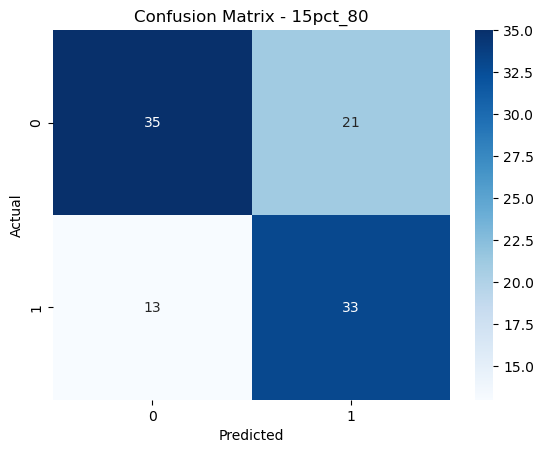

In [11]:
results = []
for name, path in split_variants.items():
    print(f"\n==== Running CNN on {name} ====")
    X_train = pd.read_csv(path / "X_train.csv", index_col=0)
    X_test = pd.read_csv(path / "X_test.csv", index_col=0)
    y_train = pd.read_csv(path / "y_train.csv", index_col=0).squeeze()
    y_test = pd.read_csv(path / "y_test.csv", index_col=0).squeeze()

    acc = train_and_evaluate_cnn(X_train, X_test, y_train, y_test, name)
    results.append((name, X_train.shape[1], acc))


In [12]:
# Final summary
df_cnn_results = pd.DataFrame(results, columns=["Split", "Num Features", "Test Accuracy"])
df_cnn_results = df_cnn_results.sort_values("Test Accuracy", ascending=False).reset_index(drop=True)

print("\Final CNN Test Accuracy Comparison:")
df_cnn_results

\Final CNN Test Accuracy Comparison:


,Split,Num Features,Test Accuracy
0,15pct_80,5870,0.6667
